In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_path = '/content/drive/MyDrive/STAT/AMZN_Clean.csv'
# Load the CSV file, parse dates, and remove timezone
df = pd.read_csv(df_path, parse_dates=['Date'])
df['Date'] = df['Date'].dt.tz_localize(None)  # Remove timezone info
df.set_index('Date', inplace=True)

df

,Unnamed: 0,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2019-01-02,0,76.956497,76.956497,77.667999,73.046501,73.260002,159662000
2019-01-03,1,75.014000,75.014000,76.900002,74.855499,76.000504,139512000
2019-01-04,2,78.769501,78.769501,79.699997,75.915497,76.500000,183652000
2019-01-07,3,81.475502,81.475502,81.727997,79.459503,80.115501,159864000
2019-01-08,4,82.829002,82.829002,83.830498,80.830498,83.234497,177628000
...,...,...,...,...,...,...,...
2023-12-22,1253,153.419998,153.419998,154.350006,152.710007,153.770004,29480100
2023-12-26,1254,153.410004,153.410004,153.979996,153.029999,153.559998,25067200
2023-12-27,1255,153.339996,153.339996,154.779999,153.119995,153.559998,31434700


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5007.113, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5008.844, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5008.858, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5005.116, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5008.830, Time=0.60 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 6.796 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2501.558
Date:                Sun, 17 Nov 2024   AIC                           5005.116
Time:                        03:38:44   BIC                           5010.029
Sample:                             0   HQIC                          5006.983
               

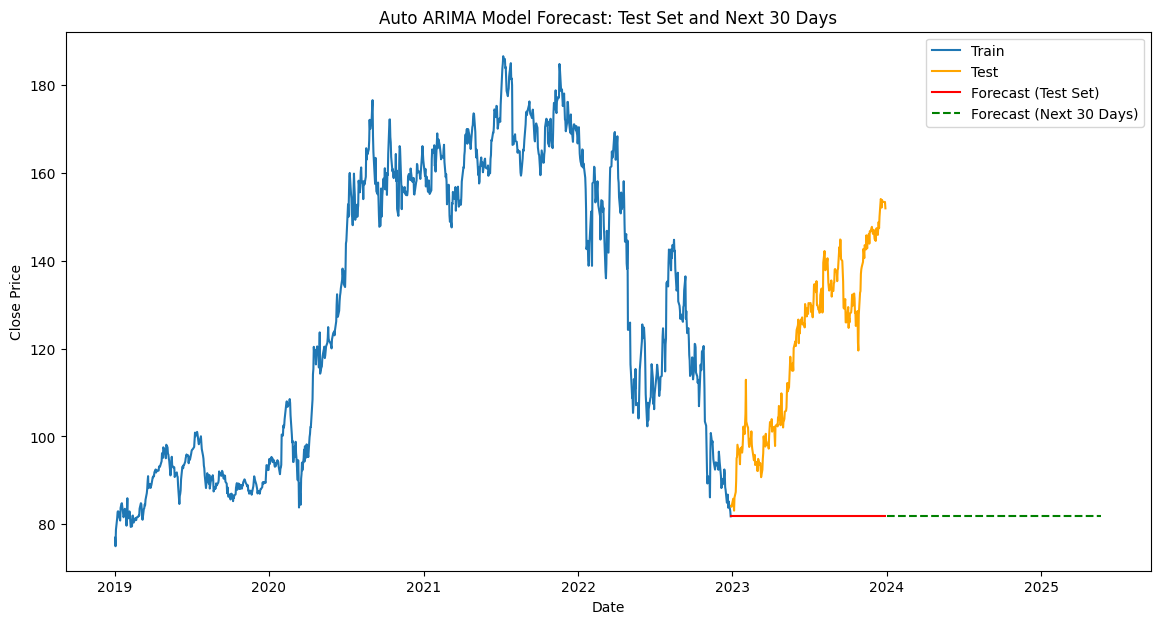

In [6]:
#Assuming 'df' is your DataFrame and 'Close' is the column with daily closing prices
# Train-test split
train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
train, test = df['Close'][:train_size], df['Close'][train_size:]

# Fit auto_arima model on the training data
model = auto_arima(train, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Summary of the model
print(model.summary())

# Forecast for the test period + 30 days
forecast_test = model.predict(n_periods=len(test))  # Forecast for test set
forecast_next_30 = model.predict(n_periods=365)     # Forecast for next 30 days

# Create indices for the 30-day forecast
forecast_next_30_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=365, freq='B')

# Evaluation Metrics for Test Set
mae = mean_absolute_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))
mape = np.mean(np.abs((test - forecast_test) / test)) * 100

# Directional Accuracy for Test Set
direction_true = np.sign(np.diff(test.values))  # True price direction
direction_pred = np.sign(np.diff(forecast_test))  # Predicted price direction
directional_accuracy = np.mean(direction_true == direction_pred) * 100

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Directional Accuracy (DA): {directional_accuracy:.2f}%")

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot train and test sets
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')

# Plot forecast for the test set
plt.plot(test.index, forecast_test, label='Forecast (Test Set)', color='red')

# Plot forecast for the next 30 days
plt.plot(forecast_next_30_index, forecast_next_30, label='Forecast (Next 30 Days)', color='green', linestyle='--')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Auto ARIMA Model Forecast: Test Set and Next 30 Days')
plt.legend()
plt.show()


Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.1324 - val_loss: 0.0061
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0112 - val_loss: 0.0019
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0074 - val_loss: 0.0027
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0062 - val_loss: 0.0018
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0060 - val_loss: 0.0017
Epoch 9/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 10/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 11/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0054 - val_loss: 0.0014
Epoch 12/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0

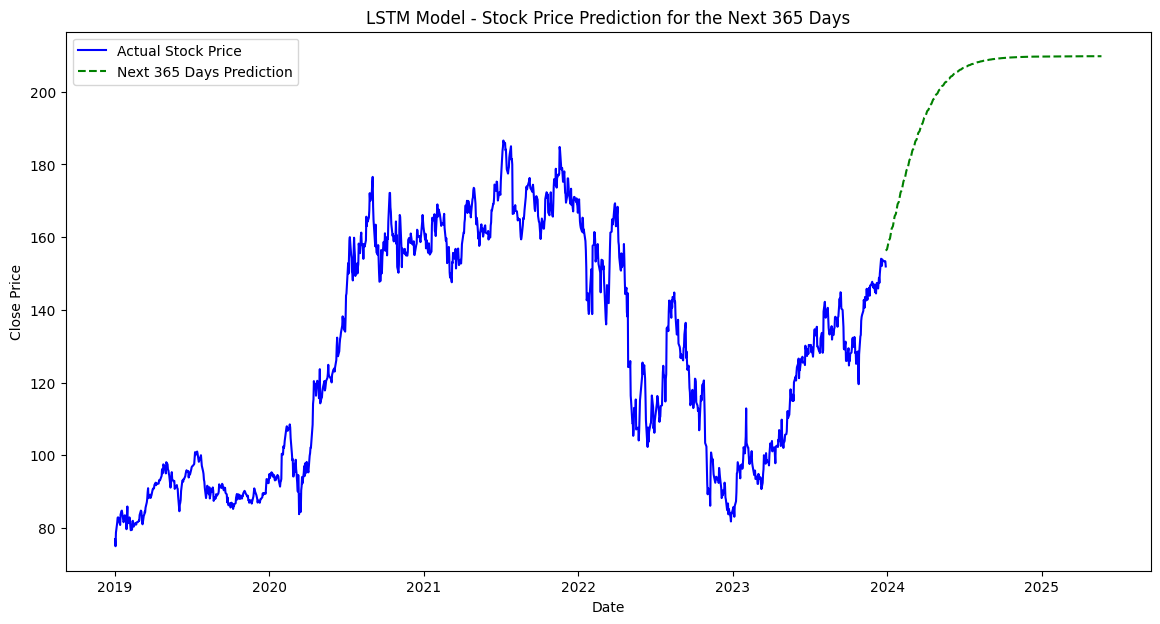

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming 'df' is your DataFrame and 'Close' is the column with daily closing prices
# Convert to numpy array for scaling and reshape
data = df[['Close']].values

# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Define sequence length and prepare the dataset
sequence_length = 60  # This means each input sequence will be 60 days of past data
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data to fit LSTM model (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_test, y_test))

# Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Undo scaling

# Inverse transform the actual test values as well
y_test_scaled = scaler.inverse_transform([y_test])
y_test_scaled = y_test_scaled[0]

# Predict the next 30 days
last_60_days = scaled_data[-sequence_length:]  # Get the last 60 days from the dataset
future_predictions = []
input_sequence = last_60_days

for _ in range(365):  # Predict for the next 30 days
    input_sequence = np.reshape(input_sequence, (1, sequence_length, 1))  # Reshape to fit the model
    next_pred = model.predict(input_sequence)  # Predict the next day
    future_predictions.append(next_pred[0][0])  # Append the prediction
    # Update the sequence: remove the first value and append the new prediction
    input_sequence = np.append(input_sequence[:, 1:, :], [[next_pred[0]]], axis=1)

# Transform future predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame for the next 30 days
last_date = df.index[-1]
future_dates = pd.date_range(last_date, periods=365, freq='B')  # Create business day indices
future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted'])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Actual Stock Price', color='blue')
plt.plot(future_df['Predicted'], label='Next 365 Days Prediction', color='green', linestyle='--')
plt.title('LSTM Model - Stock Price Prediction for the Next 365 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

